<a href="https://colab.research.google.com/github/h4rrye/gene_length_prediction_using_Pytorch/blob/main/gene_length_prediction_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Creating a Neural Network to predict the length of a gene in mouse.**

In [245]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import tqdm as tqdm
import random
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline


In [6]:
# load the working dataset

# this data was worked upon in the previous project at 'https://github.com/h4rrye/biological_vs_physical_genome'

url = 'https://raw.githubusercontent.com/h4rrye/biological_vs_physical_genome/refs/heads/main/data/processed/genome_table_mapped.csv'

df = pd.read_csv(url)
df.sample(10)

,gene_id,gene_name,gene_start,gene_end,strand,chr,TSS,TES,gene_length,tss_bin,fpkm,esc_max_exp,npc_max_exp,expression_breadth,rep_timing,dist_from_surf,dist_from_com,tasa
30534,ENSMUSG00000105767,Gm43607,121711611,121712428,-1,chr3,121712428,121711611,817,121720000,NaN,NaN,NaN,NaN,1.252862,NaN,NaN,0
10466,ENSMUSG00000115799,Vmn1r19,57403780,57406034,1,chr6,57403780,57406034,2254,57400000,0.0,NaN,NaN,NaN,-1.005842,NaN,NaN,0
4899,ENSMUSG00000114581,Gm8277,36558466,36559065,-1,chr13,36559065,36558466,599,36560000,NaN,NaN,NaN,NaN,-0.415186,NaN,NaN,0
19613,ENSMUSG00000060017,Olfr121,37748855,37753169,1,chr17,37748855,37753169,4314,37760000,0.0,NaN,NaN,0.0,-1.730510,NaN,NaN,0
18896,ENSMUSG00000079553,Kifc1,33875659,33890661,-1,chr17,33890661,33875659,15002,33880000,36.0,NaN,NaN,23.0,1.050214,NaN,NaN,0
26992,ENSMUSG00000094190,Gm25451,10480365,10480485,1,chr2,10480365,10480485,120,10480000,NaN,NaN,NaN,NaN,-0.613991,NaN,NaN,0
18436,ENSMUSG00000024043,Arhgap28,67842713,68004120,-1,chr17,68004120,67842713,161407,68000000,0.0,2.08083,4.61089,32.0,-0.367417,NaN,NaN,0
36120,ENSMUSG00000075893,Gm25538,12700039,12700145,1,chr12,12700039,12700145,106,12720000,NaN,0.00000,0.00000,NaN,1.693359,NaN,NaN,0
45531,ENSMUSG00000109116,Sycp1-ps1,18786332,18789099,1,chr7,18786332,18789099,2767,18800000,NaN,NaN,NaN,NaN,0.626484,NaN,NaN,0
44003,ENSMUSG00000094233,Gm21276,38763034,38768184,-1,chr7,38768184,38763034,5150,38760000,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0


In [115]:
# filtering only the first chromosome
chr1 = df[df.chr == 'chr1'].copy()

# cleaning the data
chr1['log2_fpkm'] = np.log2(chr1.fpkm.fillna(0) + 1)
chr1['esc_max_exp'] = chr1['esc_max_exp'].fillna(0)
chr1['npc_max_exp'] = chr1['npc_max_exp'].fillna(0)
chr1['expression_breadth'] = chr1['expression_breadth'].fillna(0)
chr1 = chr1.drop(columns=['gene_id', 'gene_name', 'gene_start', 'gene_end', 'chr', 'TSS', 'TES', 'tss_bin', 'fpkm'])
chr1.dropna(inplace=True)
chr1.info()
chr1.sample(10)


<class 'pandas.core.frame.DataFrame'>
Index: 3411 entries, 1 to 9410
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   strand              3411 non-null   int64  
 1   gene_length         3411 non-null   int64  
 2   esc_max_exp         3411 non-null   float64
 3   npc_max_exp         3411 non-null   float64
 4   expression_breadth  3411 non-null   float64
 5   rep_timing          3411 non-null   float64
 6   dist_from_surf      3411 non-null   float64
 7   dist_from_com       3411 non-null   float64
 8   tasa                3411 non-null   int64  
 9   log2_fpkm           3411 non-null   float64
dtypes: float64(7), int64(3)
memory usage: 293.1 KB


,strand,gene_length,esc_max_exp,npc_max_exp,expression_breadth,rep_timing,dist_from_surf,dist_from_com,tasa,log2_fpkm
2949,1,83,0.98310,0.00000,0.0,-0.894758,1.137934,0.523927,0,0.000000
6991,1,18793,0.00000,0.00000,0.0,-3.228810,0.492320,0.121002,9,0.000000
2810,-1,13019,14.10576,16.04312,32.0,-0.259374,0.614991,3.316792,0,4.906891
9337,-1,1817,0.00000,0.00000,0.0,-0.060804,0.806886,0.183276,0,0.000000
14,1,3175,634.44480,255.48633,32.0,1.112014,0.793660,2.695702,0,8.451211
8141,1,106,0.00000,0.00000,0.0,1.104787,0.806913,1.490359,14,0.000000
6861,1,18979,0.00000,0.00000,32.0,1.530933,0.690548,1.384425,0,4.754888
9409,1,12715,0.00000,0.00000,0.0,0.247092,0.835792,0.262455,0,0.000000
5203,-1,10631,18.31764,0.50685,0.0,2.144930,0.488244,1.668911,0,0.000000
9234,-1,1300,0.00000,0.00000,0.0,0.453337,0.883354,1.403778,0,0.000000


# Create the Nueral Network Model

In [203]:


# create the nueral network model

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(9, 150)
        self.fc2 = nn.Linear(150, 300)
        self.fc3 = nn.Linear(300, 100)
        self.out = nn.Linear(100, 1)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.out(X)

        return X

torch.manual_seed(33)
model = Network()



# Preping Data for the model
 **`log2_fpkm`**, **`esc_max_exp`** and **`npc_max_exp`** as LABELS

In [ ]:

# create a data class for the model with features and labels

class genome_table_tensor(Dataset):             # >> using the Dataset function from torch.utils.data

    def __init__(self, X, y):
        self.X = torch.Tensor(X.to_numpy())
        self.y = torch.Tensor(y.to_numpy())

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]



# split the data intor train and test datasets

yfs = chr1['gene_length']         # cycle among log2_fpkm, esc and npc max exp.
Xfs = chr1.drop(columns=['gene_length'])

X_train, X_test, y_train, y_test = train_test_split(Xfs, yfs, test_size=0.3, random_state=33)


dataset_train = genome_table_tensor(X_train, y_train)
dataset_test = genome_table_tensor(X_test, y_test)

batch_size = 1
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=True)





# transforming/normalizing the data         >>  making mean=0 and sd=1

scaler = StandardScaler()
chr1_scaled = scaler.fit_transform(chr1)
chr1_scaled = pd.DataFrame(chr1_scaled, columns=chr1.columns)




# define criterion and optimizer function
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)





# Train the Model

In [ ]:



# train the model

epochs = 5
train_losses = []
test_losses = []
avg_test_losses = []
train_correct = []
test_corres = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    for b ,(X_train, y_train) in enumerate(train_loader):
        b += 1

        optimizer.zero_grad()
        y_pred = model.forward(X_train)
        loss = criterion(y_pred, y_train.unsqueeze(1))


        loss.backward()
        optimizer.step()


        # print results
        #if b % 20 == 0:
        #   print (f'Epoch : {i}, Batch : {b}, Loss : {loss.item()}')
    train_losses.append(loss)


    # test the model
    with torch.no_grad():
        test_loss = 0
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            test_loss = criterion(y_val, y_test.unsqueeze(1)).item()

            if b % 100 == 0:
                print (f'Epoch : {i}, Batch : {b}, Test Loss : {test_loss:.4f}')
        avg_test_loss = test_loss / len(test_loader)
        avg_test_losses.append(avg_test_loss)
        test_losses.append(test_loss)


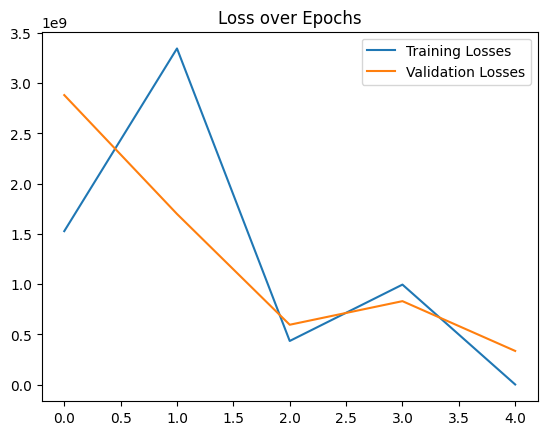

In [265]:


# plot the loss at epochs

trn_losses = [tl.item() for tl in train_losses]

plt.plot(trn_losses, label='Training Losses')
plt.plot(test_losses, label='Validation Losses')
plt.title('Loss over Epochs')
plt.legend()

In [271]:
# run a random entry through the model and check the result

 model.eval()

i = random.randint(0, 100)
with torch.no_grad():
    input_tensor = torch.FloatTensor(Xfs.iloc[i].values)
    prediction = model(input_tensor)

print (f"{prediction.item():.0f}", yfs.iloc[i])

4012 2559


# END